### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
from zipfile import ZipFile
import random
import networkx as nx
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Read file and data preprocess

#### Read scooter data in GNV: Veo Ride

In [2]:
GNV_scooter_data = pd.read_csv('GNV_scooter_data.csv')
GNV_scooter_data = GNV_scooter_data.dropna()
GNV_scooter_data = GNV_scooter_data.drop(columns = {'Rides Ride ID', 'Rides Vehicle Type'})
GNV_scooter_data = GNV_scooter_data.rename(columns = {'Rides Ride Started At Local Date': 'Start_date',
                                                      'Rides Ride Started At Local Time': 'Start_time',
                                                      'Rides Ride Ended At Local Time': 'End_time',
                                                      'Rides Lng Pickup': 'Start_lng',
                                                      'Rides Lat Pickup': 'Start_lat',
                                                      'Rides Lng Dropoff': 'End_lng',
                                                      'Rides Lat Dropoff': 'End_lat'})
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data[['Start_lng', 'Start_lat']].values.tolist()
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data['Start_coordinate'].apply(Point)
GNV_scooter_data['End_coordinate'] = GNV_scooter_data[['End_lng', 'End_lat']].values.tolist()
GNV_scooter_data['End_coordinate'] = GNV_scooter_data['End_coordinate'].apply(Point)
GNV_scooter_data['Start_date'] = pd.to_datetime(GNV_scooter_data['Start_date'])
GNV_scooter_data['Start_time'] = pd.to_datetime(GNV_scooter_data['Start_time'])
GNV_scooter_data['End_time'] = pd.to_datetime(GNV_scooter_data['End_time'])
print(len(GNV_scooter_data))
GNV_scooter_data.head()

170029


,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444)
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678)
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269)
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047)
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333)


#### Select scooter data within GNV

In [3]:
fl_city_boundary = gpd.read_file('Map/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE'].reset_index(drop=True)
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'].to_crs('epsg:4326')

# GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)

index_within_gnv = []
for ii in range (len(GNV_scooter_data)):
    if (Gainesville_boundary['geometry'].contains(GNV_scooter_data.Start_coordinate.iloc[ii])[0] and Gainesville_boundary['geometry'].contains(GNV_scooter_data.End_coordinate.iloc[ii])[0]):
        index_within_gnv.append(ii)
index_within_gnv = np.array(index_within_gnv)
GNV_scooter_data = GNV_scooter_data.iloc[index_within_gnv]
print(len(GNV_scooter_data))

169147


#### Compute geometric distance

In [4]:
start_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['Start_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
end_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['End_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
GNV_scooter_data['Geometric Distance in Miles'] = start_geo.distance(end_geo) * 0.00062137
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678


#### Compute trip duration

In [5]:
GNV_scooter_data['Trip Duration in Minutes'] = (GNV_scooter_data['End_time'] - GNV_scooter_data['Start_time']).dt.total_seconds()/60
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] >= 0].reset_index(drop=True)
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] <= 360].reset_index(drop=True)
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333


#### Trip duration and distance distribution

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\1656251754.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=GNV_scooter_data['Trip Duration in Minutes'], kde = False, bins=40, norm_hist = True, color='grey',


Text(0, 0.5, 'Probability density')

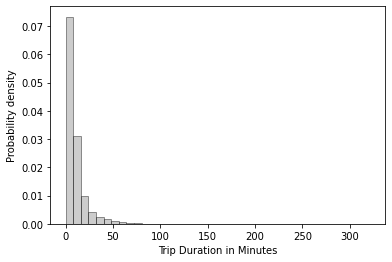

In [6]:
## trip duration distribution
sns.distplot(a=GNV_scooter_data['Trip Duration in Minutes'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Trip Duration in Minutes')
plt.ylabel('Probability density')

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\1051621780.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=GNV_scooter_data['Geometric Distance in Miles'], kde = False, bins=40, norm_hist = True, color='grey',


Text(0, 0.5, 'Probability density')

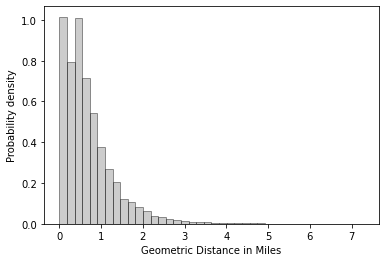

In [7]:
## geometric distance distribution
sns.distplot(a=GNV_scooter_data['Geometric Distance in Miles'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Geometric Distance in Miles')
plt.ylabel('Probability density')

#### Add temporal attributes for trips

In [8]:
# add day of a week and hour of a day
# The first recorded data happened in 2021-06-15 (Tuesday)
GNV_scooter_data['Start_year'] = GNV_scooter_data['Start_time'].dt.year
GNV_scooter_data['Start_month'] = GNV_scooter_data['Start_time'].dt.month
GNV_scooter_data['Start_day'] = GNV_scooter_data['Start_time'].dt.day
for i in range (len(GNV_scooter_data)):
    time_delay = (GNV_scooter_data['Start_date'].loc[i] - GNV_scooter_data['Start_date'].iloc[-1]).days + 2
    GNV_scooter_data.at[i, 'Start_day_of_week'] = time_delay - int(time_delay/7)*7
GNV_scooter_data['Start_hour'] = GNV_scooter_data['Start_time'].dt.hour
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000,2024,1,5,5.0,1
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667,2024,1,5,5.0,6
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000,2024,1,5,5.0,11
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667,2024,1,5,5.0,9
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333,2024,1,5,5.0,9


### Temporal Distribution

#### Monthly variations

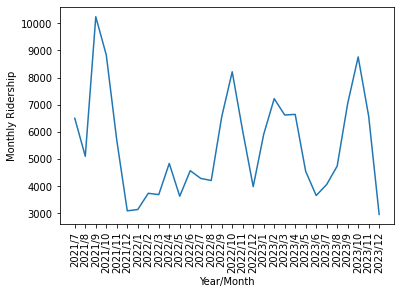

In [9]:
GNV_month_counts = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month']]).value_counts().reset_index()
GNV_month_counts = GNV_month_counts.rename(columns = {0: 'Monthly Ridership'})
GNV_month_counts = GNV_month_counts.sort_values(by=['Start_year', 'Start_month']).reset_index(drop=True)
GNV_month_counts['Year-Month'] = GNV_month_counts['Start_year'].astype(str) + "/" + GNV_month_counts['Start_month'].astype(str)
plt.plot(GNV_month_counts['Year-Month'].iloc[1:-1], GNV_month_counts['Monthly Ridership'].iloc[1:-1])
plt.xlabel('Year/Month')
plt.ylabel('Monthly Ridership')
plt.xticks(rotation = 90)
plt.show()

#### Weekly variations

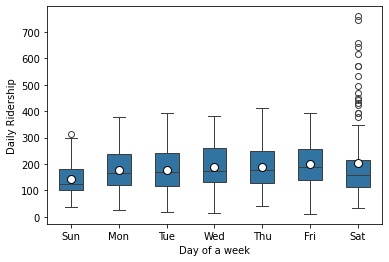

In [10]:
#GNV_start_day_ridership
GNV_week_day_time = GNV_scooter_data.groupby(['Start_year', 'Start_month', 'Start_day'])['Start_day_of_week'].mean().reset_index()
GNV_week_day_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day']].value_counts()).reset_index()
GNV_week_day_ridership = GNV_week_day_ridership.rename(columns = {0: 'Daily Ridership'})
GNV_week_day_ridership = GNV_week_day_time.merge(GNV_week_day_ridership, how = 'left', on = ['Start_year', 'Start_month', 'Start_day'])

# Week distribution

# draw boxplot
sns.boxplot(x = 'Start_day_of_week', y = 'Daily Ridership', data = GNV_week_day_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Day of a week')
plt.ylabel('Daily Ridership')
plt.xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

#### Hourly variations

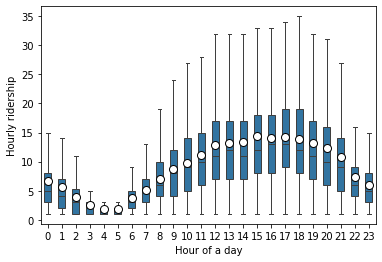

In [11]:
# JAX_start_hour_ridership
GNV_day_hour_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day', 'Start_hour']].value_counts()).reset_index()
GNV_day_hour_ridership = GNV_day_hour_ridership.rename(columns = {0: 'Hourly Ridership'})

# Hourly distribution

# draw boxplot without displaying outliers
sns.boxplot(x = 'Start_hour', y = 'Hourly Ridership', data = GNV_day_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of a day')
plt.ylabel('Hourly ridership')
plt.show()

### Input Spatial Information

#### Census block with geo info

In [12]:
# input census block information (geometry), we need geometry information that we can add into csv files
fl_cenblkgrp = gpd.read_file('Map/cenblkgrp_2020_may23.shp')
fl_GNV_cenblkgrp = fl_cenblkgrp.loc[fl_cenblkgrp['COUNTY'] == 1]
fl_GNV_cenblkgrp['geometry'] = fl_GNV_cenblkgrp['geometry'].to_crs('epsg:4326')
fl_GNV_cenblkgrp = fl_GNV_cenblkgrp.reset_index(drop=True)

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### census attributes in Alachua

In [13]:
# read fl Duval attributes
fl_GNV_tract_att = pd.read_csv('Map/fl_Alachua_tract_attribute.csv')
fl_GNV_tract_att = fl_GNV_tract_att.drop(columns = {'TRACT', 'BLKGRP', 'geometry'})
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att[['LON', 'LAT']].values.tolist()
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att['coordinates'].apply(Point)
fl_GNV_tract_att['GEOID'] = fl_GNV_tract_att['GEOID'].astype('str').astype('object')
fl_GNV_tract_att = fl_GNV_tract_att.merge(fl_GNV_cenblkgrp[['GEOID', 'TRACT', 'BLKGRP', 'geometry']], how = 'left', on = 'GEOID')
print(len(fl_GNV_tract_att))

160


#### census attributes in GNV

In [14]:
ct_index_within_gnv = []
for jj in range (len(fl_GNV_tract_att)):
    if Gainesville_boundary['geometry'].contains(fl_GNV_tract_att.geometry.iloc[jj])[0]:
        ct_index_within_gnv.append(jj)
fl_GNV_tract_att = fl_GNV_tract_att.iloc[ct_index_within_gnv]
print(len(fl_GNV_tract_att))

59


#### Show maps of census tracts, scooter trip, and basemap

(-82.43244846431782, -82.21231861289532, 29.58878255923895, 29.78745371130791)

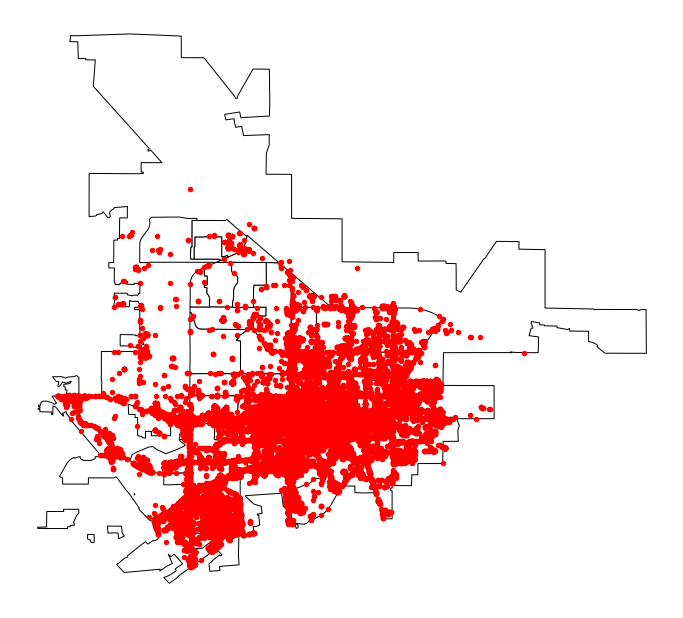

In [15]:
fl_GNV_tract_att = gpd.GeoDataFrame(fl_GNV_tract_att)
GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)
    
# draw a base map of duval boundary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = fl_GNV_tract_att.plot(ax=base1, color = 'white', edgecolor = 'black') # color='#e32636'
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

#### GNV RTS bus stops and transportation POI

In [16]:
## Bus Stop
gnv_rts_bus_stop = gpd.read_file('Map/RTSBusStops_Spring2025.shp')

## Transportation POI
alachua_poi = gpd.read_file('Map/alachua_county_poi.geojson')
# residential_poi_list = ['grave_yard', 'shelter', 'refuge', 'townhall']
# education_poi_list = ['school', 'kindergarten', 'conference_centre', 'research_institute', 'university', 'college', 'dancing_school', 'music_school', 'tutor', 'prep_school', 'language_school']
# cultural_poi_list = ['hospital (historic)', 'bell', 'arts_centre', 'library', 'planetarium', 'theatre', 'theatre (historic)', 'archive', 'gallery', 'public_bookcase']
# recreational_poi_list = ['bar', 'biergarten', 'alcohol', 'karaoke_box', 'music_venue', 'fountain', 'bench', 'social_club', 'cinema', 'studio', 'pub', 'dojo', 'nightclub', 'stripclub']
# social_poi_list = ['community_centre', 'animal_shelter', 'give_box', 'chair', 'lounger', 'trailer_park', 'smoking_area', 'telephone', 'library_dropoff', 'social_centre', 'recycling', 'nursing_home', 'social_facility', 'childcare', 'drinking_water', 'toilets', 'waste_basket']
transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 'fuel', 'taxi', 'bus_station']
# commercial_poi_list = ['bank', 'cloakroom', 'restaurant', 'spa', 'parcel_locker', 'internet_cafe',  'bbq', 'fast_food', 'cafe', 'car_wash', 'loading_dock', 'marketplace',  'animal_boarding', 'events_venue', 'dry_cleaner', 'nail_salon', 'check_cashing', 'catering', 'ice_cream', 'money_transfer', 'money_transfer;notary_public', 'vending_machine', 'atm', 'coworking_space', 'food_court', 'office']
# government_poi_list = ['post_office', 'courthouse', 'government']
# religion_poi_list = ['place_of_worship', 'crypt', 'place_of_meditation']
# health_poi_list = ['hospital', 'doctors', 'clinic', 'pharmacy', 'veterinary', 'dentist', 'first_aid', 'personal_trainer']
# publicsafety_poi_list = ['fire_station', 'police', 'border_control']

print(len(alachua_poi))

## only keep transportation poi in gnv
gnv_poi = alachua_poi[Gainesville_boundary.geometry.loc[0].contains(alachua_poi.geometry)].reset_index(drop = True)
print(len(gnv_poi))
gnv_trans_poi = gnv_poi[gnv_poi.amenity.isin(transportation_poi_list)].reset_index(drop=True)
print(len(gnv_trans_poi))
gnv_trans_poi.head()

3890
2936
1737


,element_type,osmid,amenity,ele,name,geometry
0,node,84910124,parking_entrance,None,None,POINT (-82.32921 29.65110)
1,node,581350983,parking,None,None,POINT (-82.30620 29.62157)
2,node,583406704,bicycle_parking,None,None,POINT (-82.34506 29.64801)
3,node,1636758280,parking_entrance,None,None,POINT (-82.35072 29.64364)
4,node,1638150345,parking_entrance,None,None,POINT (-82.34142 29.64099)


### Divide GNV into small service areas

#### Strategy 1: grid-based division

4404


(-82.43299999663775, -82.21092661929956, 29.58866048736907, 29.789117830924578)

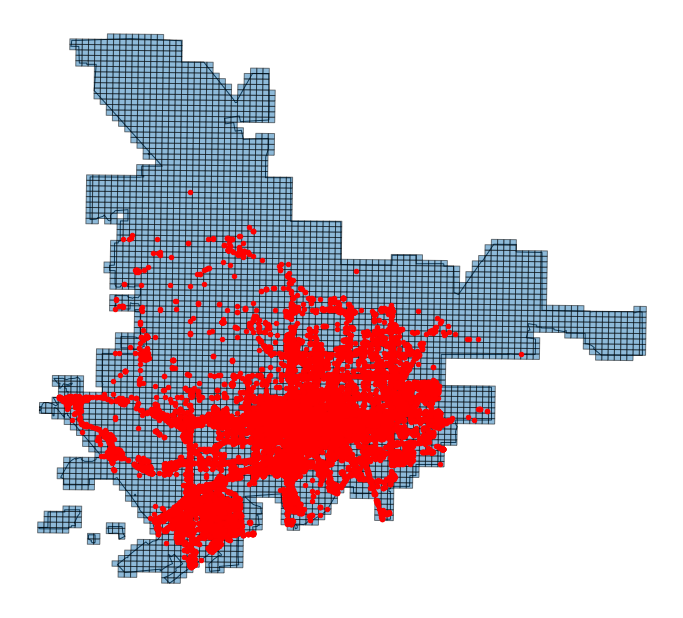

In [23]:
from shapely.geometry import box

def generate_grid(multipolygon, grid_area_threshold):
    bounds = multipolygon.bounds  # Get bounding box (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds

    # Estimate grid size based on area
    # total_area = multipolygon.area
    # piece_area = total_area / num_pieces

    #grid_size = (piece_area ** 0.5)  # Approximate square cell size
    grid_size = (grid_area_threshold ** 0.5)

    # Generate grid cells
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    grid_polygons = [
        box(x, y, x + grid_size, y + grid_size)
        for x in x_coords for y in y_coords
    ]

    # Convert to GeoDataFrame and keep only those inside the multipolygon
    grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons)
    grid_gdf = grid_gdf[grid_gdf.intersects(multipolygon)]

    return grid_gdf

Gainesville_boundary_crs = Gainesville_boundary.to_crs(epsg=3087)
multipolygon = Gainesville_boundary_crs.geometry.iloc[0]  # Load MultiPolygon
grid_gdf_crs = generate_grid(multipolygon, grid_area_threshold=40000) # 200*200
grid_gdf = grid_gdf_crs.set_crs(epsg=3087).to_crs(epsg=4326)
print(len(grid_gdf))

# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = grid_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

(-82.43299999663775, -82.21092661929956, 29.58866048736907, 29.789117830924578)

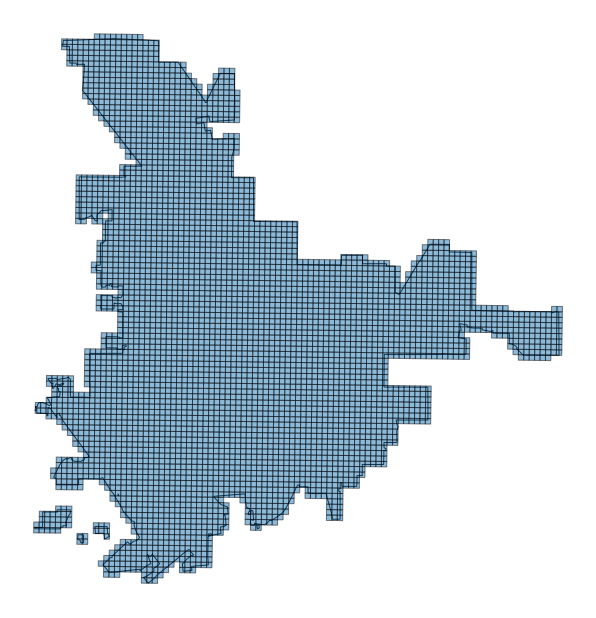

In [26]:
# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = grid_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

In [28]:
grid_centroid_gdf = grid_gdf.reset_index(drop=True)
grid_centroid_gdf['centroid'] = grid_centroid_gdf['geometry'].centroid
grid_centroid_gdf['latitude'] = grid_centroid_gdf['centroid'].y
grid_centroid_gdf['longitude'] = grid_centroid_gdf['centroid'].x

## days = 934 from 2021-6-15 to 2024-1-5
grid_centroid_gdf['departure_rate'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['arrival_rate'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['dist_transPOI'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['num_transPOI'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['dist_bus_stop'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['num_bus_stop'] = np.zeros(len(grid_centroid_gdf))

for ii in range (len(grid_centroid_gdf)):
    dist_transPOI_arr = []
    dist_bus_stop_arr = []
    for jj in range (len(gnv_trans_poi)):
        if grid_centroid_gdf.geometry.iloc[ii].contains(gnv_trans_poi.geometry.iloc[jj]):
            grid_centroid_gdf['num_transPOI'].iloc[ii] += 1
            dist_transPOI_arr.append(grid_centroid_gdf.centroid.iloc[ii].distance(gnv_trans_poi.geometry.iloc[jj]))
    grid_centroid_gdf['dist_transPOI'].iloc[ii] = np.mean(np.array(dist_transPOI_arr))
    for kk in range (len(gnv_rts_bus_stop)):
        if grid_centroid_gdf.geometry.iloc[ii].contains(gnv_rts_bus_stop.geometry.iloc[kk]):
            grid_centroid_gdf['num_bus_stop'].iloc[ii] += 1
            dist_bus_stop_arr.append(grid_centroid_gdf.centroid.iloc[ii].distance(gnv_rts_bus_stop.geometry.iloc[kk]))
    grid_centroid_gdf['dist_bus_stop'].iloc[ii] = np.mean(np.array(dist_bus_stop_arr))
    grid_centroid_gdf['departure_rate'].iloc[ii] = np.sum(grid_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.Start_coordinate))/934
    grid_centroid_gdf['arrival_rate'].iloc[ii] = np.sum(grid_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.End_coordinate))/934

grid_centroid_gdf.dist_transPOI.fillna(1, inplace=True)
grid_centroid_gdf.dist_bus_stop.fillna(1, inplace=True)

grid_centroid_gdf.to_csv('grid_centroid_gdf_old.csv', index = False)
grid_centroid_gdf.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3509980879.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid_gdf['centroid'] = grid_centroid_gdf['geometry'].centroid
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3509980879.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid

,geometry,centroid,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop
0,"POLYGON ((-82.42084 29.61450, -82.42081 29.616...",POINT (-82.42186 29.61541),29.615410,-82.421858,0.0,0.0,1.000000,0.0,0.000792,2.0
1,"POLYGON ((-82.42081 29.61630, -82.42078 29.618...",POINT (-82.42183 29.61721),29.617211,-82.421832,0.0,0.0,1.000000,0.0,1.000000,0.0
2,"POLYGON ((-82.42025 29.65412, -82.42023 29.655...",POINT (-82.42128 29.65504),29.655037,-82.421276,0.0,0.0,0.000489,1.0,1.000000,0.0
3,"POLYGON ((-82.42023 29.65593, -82.42020 29.657...",POINT (-82.42125 29.65684),29.656838,-82.421249,0.0,0.0,1.000000,0.0,0.000558,1.0
4,"POLYGON ((-82.41877 29.61447, -82.41874 29.616...",POINT (-82.41979 29.61539),29.615387,-82.419790,0.0,0.0,1.000000,0.0,1.000000,0.0


#### Strategy 2: randomized subdivision (Voronoi polygons)

6948


(-82.43244846431972, -82.21231861289522, 29.588782559238794, 29.78745371131117)

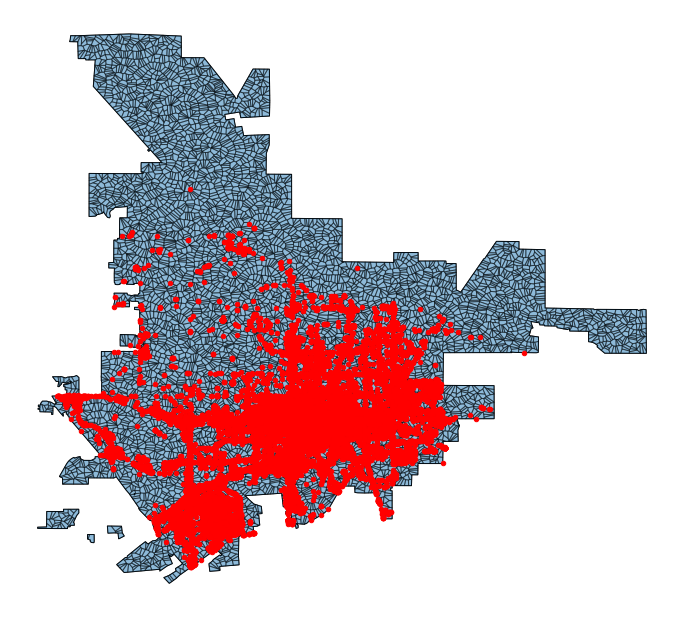

In [34]:
from shapely.geometry import MultiPolygon, MultiPoint
from shapely.ops import voronoi_diagram, clip_by_rect
import random

# Generate random points inside multipolygon
def random_points_within(poly, num_points):
    minx, miny, maxx, maxy = poly.bounds
    points = []
    while len(points) < num_points:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            points.append(p)
    return MultiPoint(points)

# Generate Voronoi polygons clipped to the boundary
def voronoi_polygons(seed_points, boundary):
    voronoi = voronoi_diagram(seed_points)
    
    # Clip Voronoi cells to the boundary
    clipped_polygons = [cell.intersection(boundary) for cell in voronoi.geoms]
    
    return [poly for poly in clipped_polygons if not poly.is_empty]

def voronoi_partition(multipolygon, area_threshold):
    seed_points = random_points_within(multipolygon, num_points=100)
    polygons = voronoi_polygons(seed_points, multipolygon)
    polygons_list = [1, polygons]
    # Refine by adding more seed points where necessary
    while any(poly.area > area_threshold for poly in polygons):
        new_seeds = []
        if (polygons_list[-1] != polygons_list[-2]):
            for poly in polygons:
                if poly.area > area_threshold:
                    centroid = poly.centroid
                    if multipolygon.contains(centroid):
                        new_seeds.append(centroid)

            # Add new points and recompute Voronoi
            seed_points = MultiPoint(list(seed_points.geoms) + new_seeds)
            polygons = voronoi_polygons(seed_points, multipolygon)
            polygons_list.append(polygons)
        else:
            break
    return gpd.GeoDataFrame(geometry=polygons)  # Convert to GeoDataFrame

Gainesville_boundary_crs = Gainesville_boundary.to_crs(epsg=3087)
multipolygon = Gainesville_boundary_crs.geometry.iloc[0]  # Load MultiPolygon
subdivided_gdf_crs = voronoi_partition(multipolygon, area_threshold = 40000) # 200 * 200
subdivided_gdf = subdivided_gdf_crs.set_crs(epsg=3087).to_crs(epsg=4326)
print(len(subdivided_gdf))

# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = subdivided_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

(-82.43244846431972, -82.21231861289522, 29.588782559238794, 29.78745371131117)

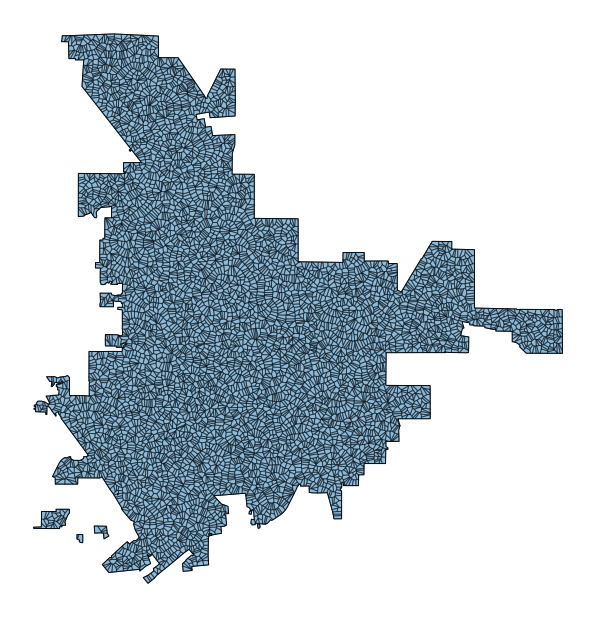

In [35]:
# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = subdivided_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
#GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

In [37]:
subdivided_centroid_gdf = subdivided_gdf.reset_index(drop=True)
subdivided_centroid_gdf['centroid'] = subdivided_centroid_gdf['geometry'].centroid
subdivided_centroid_gdf['latitude'] = subdivided_centroid_gdf['centroid'].y
subdivided_centroid_gdf['longitude'] = subdivided_centroid_gdf['centroid'].x

## days = 934 from 2021-6-15 to 2024-1-5
subdivided_centroid_gdf['departure_rate'] = np.zeros(len(subdivided_centroid_gdf))
subdivided_centroid_gdf['arrival_rate'] = np.zeros(len(subdivided_centroid_gdf))
subdivided_centroid_gdf['dist_transPOI'] = np.zeros(len(subdivided_centroid_gdf))
subdivided_centroid_gdf['num_transPOI'] = np.zeros(len(subdivided_centroid_gdf))
subdivided_centroid_gdf['dist_bus_stop'] = np.zeros(len(subdivided_centroid_gdf))
subdivided_centroid_gdf['num_bus_stop'] = np.zeros(len(subdivided_centroid_gdf))

for ii in range (len(subdivided_centroid_gdf)):
    dist_transPOI_arr = []
    dist_bus_stop_arr = []
    for jj in range (len(gnv_trans_poi)):
        if subdivided_centroid_gdf.geometry.iloc[ii].contains(gnv_trans_poi.geometry.iloc[jj]):
            subdivided_centroid_gdf['num_transPOI'].iloc[ii] += 1
            dist_transPOI_arr.append(subdivided_centroid_gdf.centroid.iloc[ii].distance(gnv_trans_poi.geometry.iloc[jj]))
    subdivided_centroid_gdf['dist_transPOI'].iloc[ii] = np.mean(np.array(dist_transPOI_arr))
    for kk in range (len(gnv_rts_bus_stop)):
        if subdivided_centroid_gdf.geometry.iloc[ii].contains(gnv_rts_bus_stop.geometry.iloc[kk]):
            subdivided_centroid_gdf['num_bus_stop'].iloc[ii] += 1
            dist_bus_stop_arr.append(subdivided_centroid_gdf.centroid.iloc[ii].distance(gnv_rts_bus_stop.geometry.iloc[kk]))
    subdivided_centroid_gdf['dist_bus_stop'].iloc[ii] = np.mean(np.array(dist_bus_stop_arr))
    subdivided_centroid_gdf['departure_rate'].iloc[ii] = np.sum(subdivided_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.Start_coordinate))/934
    subdivided_centroid_gdf['arrival_rate'].iloc[ii] = np.sum(subdivided_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.End_coordinate))/934

subdivided_centroid_gdf.dist_transPOI.fillna(1, inplace=True)
subdivided_centroid_gdf.dist_bus_stop.fillna(1, inplace=True)

subdivided_centroid_gdf.to_csv('subdivided_centroid_gdf.csv', index = False)
subdivided_centroid_gdf.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3728436496.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  subdivided_centroid_gdf['centroid'] = subdivided_centroid_gdf['geometry'].centroid
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3728436496.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,geometry,centroid,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop
0,"POLYGON ((-82.41085 29.77588, -82.41193 29.775...",POINT (-82.41105 29.77693),29.776934,-82.411047,0.0,0.0,1.000000,0.0,1.000000,0.0
1,"POLYGON ((-82.42102 29.65655, -82.42036 29.654...",POINT (-82.42129 29.65534),29.655337,-82.421287,0.0,0.0,0.000197,1.0,0.000962,1.0
2,"POLYGON ((-82.41956 29.65496, -82.41936 29.655...",POINT (-82.41853 29.65439),29.654392,-82.418532,0.0,0.0,1.000000,0.0,1.000000,0.0
3,"POLYGON ((-82.42145 29.65679, -82.42137 29.657...",POINT (-82.42008 29.65704),29.657039,-82.420076,0.0,0.0,1.000000,0.0,1.000000,0.0
4,"POLYGON ((-82.42102 29.65655, -82.42032 29.656...",POINT (-82.42028 29.65531),29.655315,-82.420280,0.0,0.0,1.000000,0.0,1.000000,0.0


#### Strategy 3: adaptive grid-based division

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3350698581.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GNV_cluster_gdf["cluster"] = kmeans.fit_predict(GNV_scooter_data[["Start_lng", "Start_lat"]])


0
4
8
12
16
20
24
28
32
36
40
44
48
51
55
59
63
67
71
74
78
82
86
89
93
97
101
105
109
113
117
121
125
129
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
191
195
199
203
207
211
215
219
223
227
231
235
239
243
247
251
255
259
263
267
271
275
279
282
286
290
294
298
302
305
309
313
317
321
325
329
333
337
341
345
349
353
357
361
365
369
373
377
381
385
389
393
397
401
405
409
413
417
421
425
429
433
437
441
445
449
453
457
461
465
469
473
477
481
485
489
493
497
501
505
509
513
517
521
525
529
533
537
541
545
549
553
557
561
565
569
573
577
581
585
589
593
597
601
605
609
613
617
621
625
629
633
637
641
645
649
653
657
661
665
669
673
677
681
685
689
693
697
701
705
709
713
717
721
725
729
733
737
741
745
749
753
757
761
765
769
773
777
781
785
789
793
797
801
805
809
813
817
821
825
829
833
837
841
845
849
853
857
861
865
869
873
877
881
885
889
893
897
901
904
908
912
916
920
924
928
932
936
940
944
948
952
956
960
964
968
972
976
980
984
988
992
996
1000
1004
1008
1012
1

(-82.43244846431972, -82.21231861289522, 29.588782559238794, 29.78745371131117)

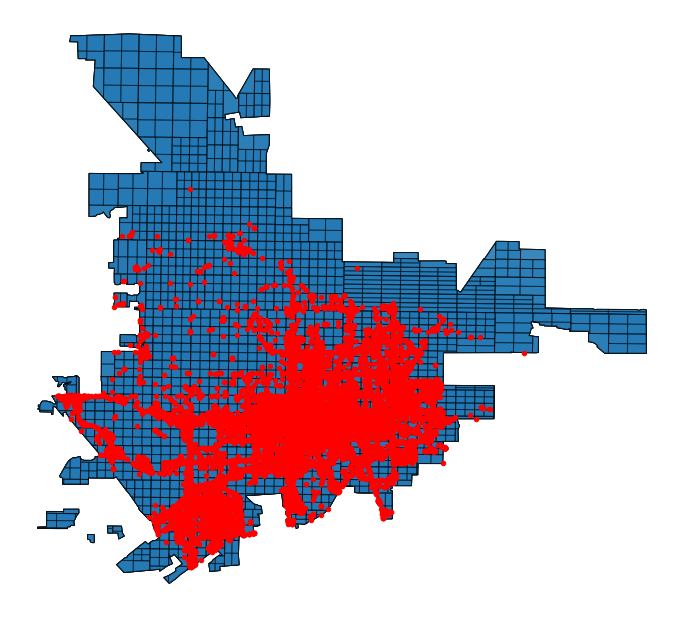

In [132]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import unary_union
from sklearn.cluster import KMeans

def adaptive_quadtree_subdivide(polygon, centroid, max_regions, base_min_area, area_threshold):
    """
    Perform an adaptive QuadTree subdivision with denser divisions in the center.
    """
    queue = [polygon]
    subdivided = []
    # centroid = polygon.centroid  # Compute the centroid

    while queue and len(subdivided) < max_regions:
        poly = queue.pop(0)  # Select the first polygon element from the queue
        # print(len(subdivided))

        # Compute distance from centroid (normalized)
        dist_min_arr = []
        for iii in range (len(centroid)):
            dist_min_arr.append(centroid.iloc[iii].geometry.distance(poly.centroid))
        dist = np.mean(np.array(dist_min_arr)) / polygon.length

        # Set adaptive minimum area (smaller near the center, larger at the periphery)
        min_area = base_min_area * (1 + 20000 * dist)  # Larger at the periphery

        # Get bounding box
        minx, miny, maxx, maxy = poly.bounds
        midx, midy = (minx + maxx) / 2, (miny + maxy) / 2  # Compute midpoints

        # Define 4 sub-polygons
        sub_polygons = [
            box(minx, midy, midx, maxy),  # Top-left
            box(midx, midy, maxx, maxy),  # Top-right
            box(minx, miny, midx, midy),  # Bottom-left
            box(midx, miny, maxx, midy),  # Bottom-right
        ]

        # Clip sub-polygons to the original polygon
        clipped = [sub.intersection(poly) for sub in sub_polygons if sub.intersects(poly)]

        # Stop subdividing if the area is too small
        for sub in clipped:
            if sub.area >= min_area:
                queue.append(sub)  # Continue subdividing
            subdivided.append(sub)  # Store the final subdivision
            
            if (len(subdivided) >= max_regions or gpd.GeoDataFrame(geometry=subdivided).area.median() <= area_threshold):
                print('NAN_1')
                break
        if gpd.GeoDataFrame(geometry=subdivided).area.median() <= area_threshold:
            print('NAN_2')
            break

    return gpd.GeoDataFrame(geometry=subdivided) # , crs="EPSG:4326"

Gainesville_boundary_crs = Gainesville_boundary.to_crs(epsg=3087)
multipolygon = Gainesville_boundary_crs.geometry.iloc[0]  # Load MultiPolygon

# Perform K-Means clustering
kmeans = KMeans(n_clusters=100, random_state=42)
GNV_cluster_gdf = GNV_scooter_data[["Start_lng", "Start_lat"]]
GNV_cluster_gdf["cluster"] = kmeans.fit_predict(GNV_scooter_data[["Start_lng", "Start_lat"]])
GNV_cluster_centroids = kmeans.cluster_centers_
GNV_scooter_centroid = []
for i in range (GNV_cluster_centroids.shape[0]):
    GNV_scooter_centroid.append(Point(GNV_cluster_centroids[i,0], GNV_cluster_centroids[i,1]))
GNV_scooter_centroid = gpd.GeoDataFrame(pd.DataFrame(GNV_scooter_centroid).rename(columns={0: "geometry"})).set_crs(epsg=4326).to_crs(epsg=3087)
quadtree_gdf_crs = adaptive_quadtree_subdivide(multipolygon, GNV_scooter_centroid, max_regions=10000, base_min_area=200, area_threshold = 20000)
quadtree_gdf = quadtree_gdf_crs.set_crs(epsg=3087).to_crs(epsg=4326)
print(len(quadtree_gdf))

# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = quadtree_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

(-82.43244846431972, -82.21231861289522, 29.588782559238794, 29.78745371131117)

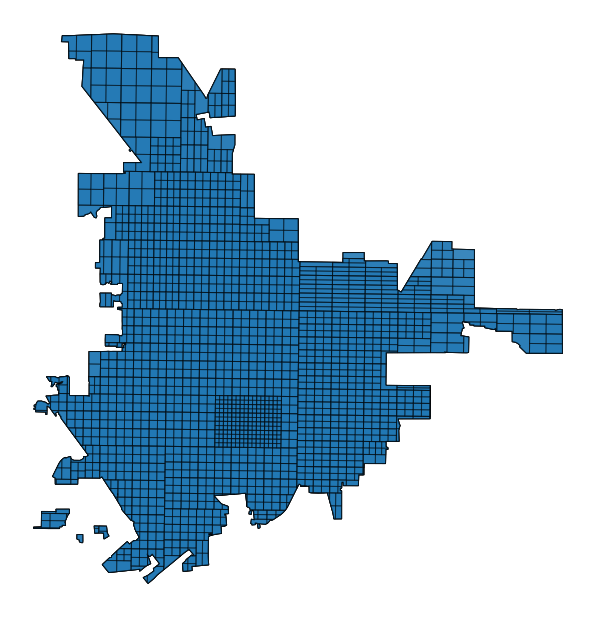

In [133]:
# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = quadtree_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

In [134]:
quadtree_centroid_gdf = quadtree_gdf.reset_index(drop=True)
quadtree_centroid_gdf['centroid'] = quadtree_centroid_gdf['geometry'].centroid
quadtree_centroid_gdf['latitude'] = quadtree_centroid_gdf['centroid'].y
quadtree_centroid_gdf['longitude'] = quadtree_centroid_gdf['centroid'].x

## days = 934 from 2021-6-15 to 2024-1-5
quadtree_centroid_gdf['departure_rate'] = np.zeros(len(quadtree_centroid_gdf))
quadtree_centroid_gdf['arrival_rate'] = np.zeros(len(quadtree_centroid_gdf))
quadtree_centroid_gdf['dist_transPOI'] = np.zeros(len(quadtree_centroid_gdf))
quadtree_centroid_gdf['num_transPOI'] = np.zeros(len(quadtree_centroid_gdf))
quadtree_centroid_gdf['dist_bus_stop'] = np.zeros(len(quadtree_centroid_gdf))
quadtree_centroid_gdf['num_bus_stop'] = np.zeros(len(quadtree_centroid_gdf))

for ii in range (len(quadtree_centroid_gdf)):
    dist_transPOI_arr = []
    dist_bus_stop_arr = []
    for jj in range (len(gnv_trans_poi)):
        if quadtree_centroid_gdf.geometry.iloc[ii].contains(gnv_trans_poi.geometry.iloc[jj]):
            quadtree_centroid_gdf['num_transPOI'].iloc[ii] += 1
            dist_transPOI_arr.append(quadtree_centroid_gdf.centroid.iloc[ii].distance(gnv_trans_poi.geometry.iloc[jj]))
    quadtree_centroid_gdf['dist_transPOI'].iloc[ii] = np.mean(np.array(dist_transPOI_arr))
    for kk in range (len(gnv_rts_bus_stop)):
        if quadtree_centroid_gdf.geometry.iloc[ii].contains(gnv_rts_bus_stop.geometry.iloc[kk]):
            quadtree_centroid_gdf['num_bus_stop'].iloc[ii] += 1
            dist_bus_stop_arr.append(quadtree_centroid_gdf.centroid.iloc[ii].distance(gnv_rts_bus_stop.geometry.iloc[kk]))
    quadtree_centroid_gdf['dist_bus_stop'].iloc[ii] = np.mean(np.array(dist_bus_stop_arr))
    quadtree_centroid_gdf['departure_rate'].iloc[ii] = np.sum(quadtree_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.Start_coordinate))/934
    quadtree_centroid_gdf['arrival_rate'].iloc[ii] = np.sum(quadtree_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.End_coordinate))/934

quadtree_centroid_gdf.dist_transPOI.fillna(1, inplace=True)
quadtree_centroid_gdf.dist_bus_stop.fillna(1, inplace=True)

quadtree_centroid_gdf.to_csv('quadtree_centroid_gdf.csv', index = False)
quadtree_centroid_gdf.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3806996328.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  quadtree_centroid_gdf['centroid'] = quadtree_centroid_gdf['geometry'].centroid
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3806996328.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quadtree_centroid_gdf['num_transPOI'].iloc[ii] += 1
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_26180\3806996328.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_transPOI_arr.append(quadtree_centroid_gdf.cen

,geometry,centroid,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop
0,"POLYGON ((-82.32196 29.68738, -82.39059 29.688...",POINT (-82.36769 29.72685),29.726851,-82.367690,0.324411,0.528908,0.030745,25.0,0.036562,64.0
1,"POLYGON ((-82.32196 29.68738, -82.32171 29.703...",POINT (-82.28496 29.69579),29.695786,-82.284964,0.292291,0.435760,0.023646,3.0,0.024517,10.0
2,"MULTIPOLYGON (((-82.32196 29.68738, -82.32288 ...",POINT (-82.36476 29.64938),29.649380,-82.364760,161.171306,160.518201,0.025510,1582.0,0.026905,544.0
3,"POLYGON ((-82.32196 29.68738, -82.22242 29.686...",POINT (-82.29214 29.66368),29.663676,-82.292141,19.302998,19.608137,0.025438,124.0,0.021642,184.0
4,"POLYGON ((-82.36691 29.73302, -82.38840 29.733...",POINT (-82.38403 29.75846),29.758462,-82.384026,0.000000,0.001071,1.000000,0.0,1.000000,0.0
